# Parameter Tuning Workflow

**Purpose**: This notebook demonstrates how to systematically explore parameter space to find configurations that produce the expected ecological dynamics.

---

## The Tuning Challenge

Our goal is to find parameter values that demonstrate:

1. **Elevation differentiation**: High elevation areas recover naturally, low elevation areas need intervention
2. **Invasive dynamics**: Invasives dominate at low elevation, are suppressed at high elevation
3. **Intervention effectiveness**: Removal and seeding help in the right places

### Sweep Design: Bundled Parameters

We sweep **5 parameters** but organize them into **3 dimensions** to keep the sweep manageable (27 vs 243 combinations):

| Dimension | Parameters Bundled | Rationale |
|-----------|-------------------|-----------|
| **Elevation Effect** | `elevationInvasiveGrowthReduction`, `seedlingElevationReduction`, `elevationInitialInvasiveReduction` | These conceptually co-vary: "stronger elevation effects" means all three increase together |
| **Growth Rate** | `invasiveBaseGrowthRate` | Independent: controls how fast invasives spread |
| **Threshold** | `nativeEstablishmentThreshold` | Independent: invasive cover level that blocks native seedlings |

### Parameter Values by Level

| Level | Elev Growth Reduction | Seedling Elev Reduction | Initial Invasive Reduction | Growth Rate | Threshold |
|-------|----------------------|------------------------|---------------------------|-------------|-----------|
| low | 10% | 15% | 25% | 8% | 20% |
| med | 20% | 25% | 40% | 15% | 35% |
| high | 30% | 35% | 55% | 25% | 50% |

**Total combinations**: 3 × 3 × 3 = **27** (not 3⁵ = 243 for full factorial)

This design assumes elevation-related parameters should move together. A full factorial sweep could reveal additional interactions but would take ~9x longer to run.

---

## Step 1: Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import os
import sys
import glob
import shutil
from pathlib import Path

# Configuration
WORKSPACE = Path('/workspace')
SWEEP_DIR = WORKSPACE / 'parameter_sweep_configs'
RESULTS_DIR = WORKSPACE / 'results' / 'sweep'  # Sweep results go here

# Add sweep directory to Python path so we can import generate_configs
sys.path.insert(0, str(SWEEP_DIR))
from generate_configs import generate_sweep_configs, clean_generated_configs, parse_csv

# Create results directory
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Simulation configuration
JAR = WORKSPACE / 'jar' / 'joshsim-fat-prod.jar'
MODEL = WORKSPACE / 'vegetation_model.josh'
BASE_PARAMS = WORKSPACE / 'configs' / 'params.jshc'
SCENARIO_CONFIG = WORKSPACE / 'configs' / 'fire_only.jshc'
FIRE_DATA = WORKSPACE / 'preprocessed' / 'fire_severity.jshd'
ELEVATION_DATA = WORKSPACE / 'preprocessed' / 'elevation.jshd'

print(f"Workspace: {WORKSPACE}")
print(f"Sweep definitions: {SWEEP_DIR / 'sweep_definitions.csv'}")
print(f"Sweep results: {RESULTS_DIR}")
print(f"Base results: {WORKSPACE / 'results' / 'base'}")

Workspace: /workspace
Sweep definitions: /workspace/parameter_sweep_configs/sweep_definitions.csv
Sweep results: /workspace/results/sweep
Base results: /workspace/results/base


---

## Step 2: Generate Sweep Configurations

Run the config generator to create `.jshc` files for each parameter combination.

In [3]:
# Generate sweep configurations using Python directly
# This calls the generate_sweep_configs function from generate_configs.py

generated_configs = generate_sweep_configs(
    csv_path=SWEEP_DIR / 'sweep_definitions.csv',
    output_dir=SWEEP_DIR,
    verbose=True
)

Generating 27 configurations from sweep_definitions.csv
  Created: low_elev_effect/low_growth/low_threshold/params.jshc
  Created: low_elev_effect/low_growth/med_threshold/params.jshc
  Created: low_elev_effect/low_growth/high_threshold/params.jshc
  Created: low_elev_effect/med_growth/low_threshold/params.jshc
  Created: low_elev_effect/med_growth/med_threshold/params.jshc
  Created: low_elev_effect/med_growth/high_threshold/params.jshc
  Created: low_elev_effect/high_growth/low_threshold/params.jshc
  Created: low_elev_effect/high_growth/med_threshold/params.jshc
  Created: low_elev_effect/high_growth/high_threshold/params.jshc
  Created: med_elev_effect/low_growth/low_threshold/params.jshc
  Created: med_elev_effect/low_growth/med_threshold/params.jshc
  Created: med_elev_effect/low_growth/high_threshold/params.jshc
  Created: med_elev_effect/med_growth/low_threshold/params.jshc
  Created: med_elev_effect/med_growth/med_threshold/params.jshc
  Created: med_elev_effect/med_growth/hig

---

## Step 3: Run Parameter Sweep

**Option A**: Run from this notebook (may take a while)

**Option B**: Run from terminal: `bash parameter_sweep_configs/run_sweep.sh`

Each configuration runs a 50-year simulation. With 27 configurations, expect ~5-10 minutes total.

In [8]:
# Run the parameter sweep using Python
# This merges configs, runs simulations, and saves results

def merge_configs(base_config: Path, sweep_config: Path, output_path: Path):
    """Merge base config with sweep overrides."""
    with open(base_config, 'r') as f:
        base_content = f.read()
    with open(sweep_config, 'r') as f:
        # Filter out comments from sweep config
        sweep_lines = [line for line in f.readlines() if not line.strip().startswith('#')]
        sweep_content = ''.join(sweep_lines)
    
    merged = base_content + "\n# === SWEEP OVERRIDES ===\n" + sweep_content
    output_path.write_text(merged)
    return output_path


def run_simulation(merged_config: Path, scenario_name: str) -> Path:
    """Run a single simulation and return the output path."""
    safe_name = scenario_name.replace('/', '_')
    output_file = RESULTS_DIR / f"{safe_name}_results.csv"
    
    # Run simulation
    result = subprocess.run(
        [
            'java', '-jar', str(JAR), 'run',
            '--data', f'params.jshc={merged_config}',
            '--data', f'scenario.jshc={SCENARIO_CONFIG}',
            '--data', f'fire.jshd={FIRE_DATA}',
            '--data', f'elevation.jshd={ELEVATION_DATA}',
            str(MODEL), 'Main'
        ],
        capture_output=True, text=True, cwd=str(WORKSPACE)
    )
    
    if result.returncode != 0:
        print(f"  ERROR: {result.stderr[:500]}")
        return None
    
    # Model outputs to results/base/output_0.csv (hardcoded in model)
    # Move it to our sweep results directory with the scenario name
    temp_output = WORKSPACE / 'results' / 'base' / 'output_0.csv'
    if temp_output.exists():
        shutil.move(str(temp_output), str(output_file))
        return output_file
    else:
        print(f"  WARNING: No output file generated at {temp_output}")
        return None


def run_parameter_sweep(configs: list, dry_run: bool = False):
    """Run all sweep configurations."""
    print("="*60)
    print("PARAMETER SWEEP RUNNER")
    print("="*60)
    print(f"Model: {MODEL}")
    print(f"Base params: {BASE_PARAMS}")
    print(f"Scenario: fire_only")
    print(f"Results: {RESULTS_DIR}")
    print(f"\nFound {len(configs)} configurations to run\n")
    
    results = []
    for i, config_path in enumerate(sorted(configs), 1):
        scenario_name = str(config_path.parent.relative_to(SWEEP_DIR))
        safe_name = scenario_name.replace('/', '_')
        merged_config = RESULTS_DIR / f"{safe_name}_merged.jshc"
        
        print(f"[{i}/{len(configs)}] Running: {scenario_name}")
        
        if dry_run:
            print(f"  [DRY RUN] Would merge: {BASE_PARAMS} + {config_path}")
            print(f"  [DRY RUN] Would output: {RESULTS_DIR / f'{safe_name}_results.csv'}")
            continue
        
        # Merge configs
        merge_configs(BASE_PARAMS, config_path, merged_config)
        
        # Run simulation
        output = run_simulation(merged_config, scenario_name)
        if output:
            print(f"  Output: {output.name}")
            results.append(output)
        print()
    
    print("="*60)
    print("SWEEP COMPLETE")
    print("="*60)
    print(f"Results saved to: {RESULTS_DIR}")
    return results


# Run the sweep (set dry_run=True to preview without executing)
# Uncomment the line below to run:

sweep_results = run_parameter_sweep(generated_configs, dry_run=False)

print("To run the sweep, uncomment the line above or run:")
print("  sweep_results = run_parameter_sweep(generated_configs)")
print("\nOr use dry_run=True to preview:")
print("  sweep_results = run_parameter_sweep(generated_configs, dry_run=True)")

PARAMETER SWEEP RUNNER
Model: /workspace/vegetation_model.josh
Base params: /workspace/configs/params.jshc
Scenario: fire_only
Results: /workspace/results/sweep

Found 27 configurations to run

[1/27] Running: high_elev_effect/high_growth/high_threshold
  Output: high_elev_effect_high_growth_high_threshold_results.csv

[2/27] Running: high_elev_effect/high_growth/low_threshold
  Output: high_elev_effect_high_growth_low_threshold_results.csv

[3/27] Running: high_elev_effect/high_growth/med_threshold


KeyboardInterrupt: 

---

## Step 4: Load and Analyze Results

Load all sweep results and compute summary metrics.

In [9]:
# Load all results
result_files = list(RESULTS_DIR.glob('*_results.csv'))
print(f"Found {len(result_files)} result files")

data = None
if len(result_files) == 0:
    print("\nNo results found. Run the sweep first:")
    print("  sweep_results = run_parameter_sweep(generated_configs)")
else:
    # Load and combine results
    all_data = []
    for f in sorted(result_files):
        df = pd.read_csv(f)
        # Extract scenario name from filename
        scenario = f.stem.replace('_results', '')
        df['scenario'] = scenario
        all_data.append(df)
    
    data = pd.concat(all_data, ignore_index=True)
    print(f"Loaded {len(data):,} rows from {len(result_files)} scenarios")
    print(f"Scenarios: {data['scenario'].unique()[:5].tolist()}{'...' if len(data['scenario'].unique()) > 5 else ''}")

Found 2 result files
Loaded 265,302 rows from 2 scenarios
Scenarios: ['high_elev_effect_high_growth_high_threshold', 'high_elev_effect_high_growth_low_threshold']


In [10]:
# Compute summary metrics for each scenario
metrics_df = None
if data is not None and len(data) > 0:
    # Get final state (step 50)
    final = data[data['step'] == data['step'].max()].copy()
    
    # Create elevation zones
    final['elev_zone'] = pd.cut(final['elevation'], 
                                bins=[0, 30, 60, 101], 
                                labels=['Low', 'Med', 'High'])
    
    # Compute metrics per scenario
    metrics = []
    for scenario in final['scenario'].unique():
        sf = final[final['scenario'] == scenario]
        
        # Overall metrics
        total_trees = sf['numAlive'].sum()
        mean_invasive = sf['invasiveCover'].mean()
        
        # By elevation zone
        low_invasive = sf[sf['elev_zone'] == 'Low']['invasiveCover'].mean()
        high_invasive = sf[sf['elev_zone'] == 'High']['invasiveCover'].mean()
        low_trees = sf[sf['elev_zone'] == 'Low']['numAlive'].sum()
        high_trees = sf[sf['elev_zone'] == 'High']['numAlive'].sum()
        
        # Differentiation score (higher = better separation)
        invasive_diff = low_invasive - high_invasive  # Want positive (more invasives at low elev)
        tree_ratio = high_trees / max(low_trees, 1)   # Want > 1 (more trees at high elev)
        
        metrics.append({
            'scenario': scenario,
            'total_trees': total_trees,
            'mean_invasive': mean_invasive,
            'low_invasive': low_invasive,
            'high_invasive': high_invasive,
            'low_trees': low_trees,
            'high_trees': high_trees,
            'invasive_diff': invasive_diff,
            'tree_ratio': tree_ratio,
        })
    
    metrics_df = pd.DataFrame(metrics)
    print("Computed metrics for all scenarios")
    print(metrics_df.head())

Computed metrics for all scenarios
                                      scenario  total_trees  mean_invasive  \
0  high_elev_effect_high_growth_high_threshold        22077       0.068993   
1   high_elev_effect_high_growth_low_threshold        21937       0.068993   

   low_invasive  high_invasive  low_trees  high_trees  invasive_diff  \
0      0.066101           0.05       6066        9255       0.016101   
1      0.066101           0.05       5970        9338       0.016101   

   tree_ratio  
0    1.525717  
1    1.564154  


---

## Step 5: Rank Configurations

Find configurations that best demonstrate the expected ecological dynamics.

In [11]:
# Rank configurations by how well they demonstrate expected ecological dynamics
ranked = None
if metrics_df is not None and len(metrics_df) > 0:
    # Scoring criteria:
    # 1. invasive_diff > 0: More invasives at low elevation (good)
    # 2. tree_ratio > 1: More trees at high elevation (good)
    # 3. high_invasive < 30: High elevation invasives are suppressed (good)
    # 4. low_invasive > 50: Low elevation has invasive problem (realistic)
    
    # Compute composite score
    metrics_df['score'] = (
        (metrics_df['invasive_diff'] > 20).astype(int) * 25 +  # Good differentiation
        (metrics_df['tree_ratio'] > 2).astype(int) * 25 +      # 2x more trees at high elev
        (metrics_df['high_invasive'] < 30).astype(int) * 25 +  # Low invasives at high elev
        (metrics_df['low_invasive'] > 50).astype(int) * 25     # High invasives at low elev
    )
    
    # Sort by score
    ranked = metrics_df.sort_values('score', ascending=False)
    
    print("TOP 10 CONFIGURATIONS")
    print("="*80)
    print(ranked[['scenario', 'score', 'invasive_diff', 'tree_ratio', 
                  'low_invasive', 'high_invasive', 'low_trees', 'high_trees']].head(10).to_string())

TOP 10 CONFIGURATIONS
                                      scenario  score  invasive_diff  tree_ratio  low_invasive  high_invasive  low_trees  high_trees
0  high_elev_effect_high_growth_high_threshold     25       0.016101    1.525717      0.066101           0.05       6066        9255
1   high_elev_effect_high_growth_low_threshold     25       0.016101    1.564154      0.066101           0.05       5970        9338


In [12]:
# Show details for the best configuration
if ranked is not None and len(ranked) > 0:
    best = ranked.iloc[0]
    print("BEST CONFIGURATION")
    print("="*60)
    print(f"Scenario: {best['scenario']}")
    print(f"Score: {best['score']}/100")
    print()
    print("Metrics:")
    print(f"  Invasive cover - Low elev: {best['low_invasive']:.1f}%")
    print(f"  Invasive cover - High elev: {best['high_invasive']:.1f}%")
    print(f"  Differentiation: {best['invasive_diff']:.1f}% more at low elev")
    print()
    print(f"  Trees - Low elev: {best['low_trees']:.0f}")
    print(f"  Trees - High elev: {best['high_trees']:.0f}")
    print(f"  Ratio: {best['tree_ratio']:.1f}x more at high elev")
    print()
    
    # Parse scenario name for parameters
    parts = best['scenario'].split('_')
    print("Parameters (from scenario name):")
    for i in range(0, len(parts)-1, 2):
        print(f"  {parts[i]}: {parts[i+1]}")

BEST CONFIGURATION
Scenario: high_elev_effect_high_growth_high_threshold
Score: 25/100

Metrics:
  Invasive cover - Low elev: 0.1%
  Invasive cover - High elev: 0.0%
  Differentiation: 0.0% more at low elev

  Trees - Low elev: 6066
  Trees - High elev: 9255
  Ratio: 1.5x more at high elev

Parameters (from scenario name):
  high: elev
  effect: high
  growth: high


---

## Step 6: Visualize Results

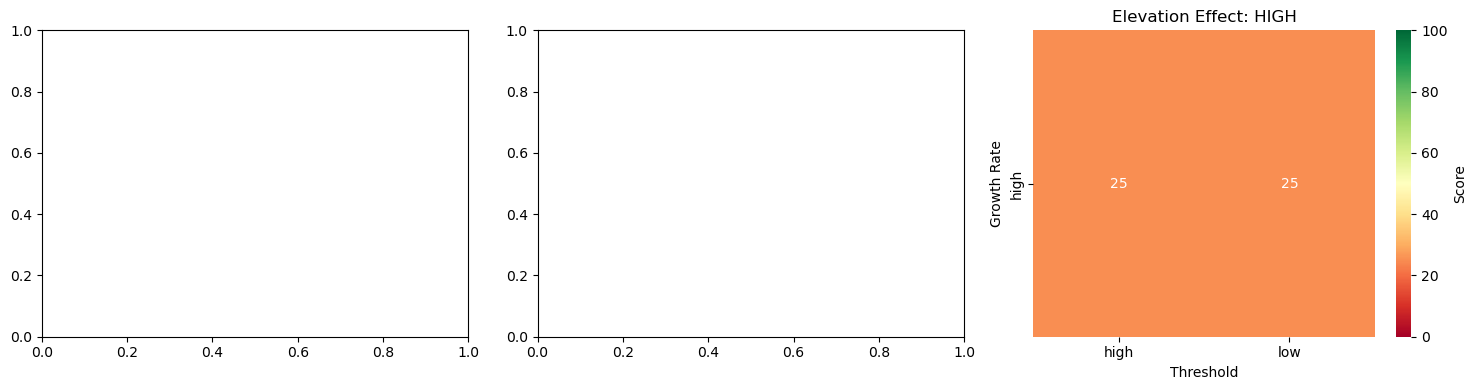

In [13]:
# Visualize sweep results as heatmaps
if metrics_df is not None and len(metrics_df) > 0:
    # Parse scenario names to extract parameter levels
    metrics_df['elev_effect'] = metrics_df['scenario'].str.extract(r'^(\w+)_elev')[0]
    metrics_df['growth'] = metrics_df['scenario'].str.extract(r'elev_effect_(\w+)_growth')[0]
    metrics_df['threshold'] = metrics_df['scenario'].str.extract(r'growth_(\w+)_threshold')[0]
    
    # Heatmap of scores
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for i, elev in enumerate(['low', 'med', 'high']):
        subset = metrics_df[metrics_df['elev_effect'] == elev]
        if len(subset) > 0:
            pivot = subset.pivot_table(index='growth', columns='threshold', 
                                       values='score', aggfunc='mean')
            sns.heatmap(pivot, ax=axes[i], annot=True, fmt='.0f', cmap='RdYlGn',
                       vmin=0, vmax=100, cbar_kws={'label': 'Score'})
            axes[i].set_title(f'Elevation Effect: {elev.upper()}')
            axes[i].set_xlabel('Threshold')
            axes[i].set_ylabel('Growth Rate')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'sweep_heatmap.png', dpi=150, bbox_inches='tight')
    plt.show()

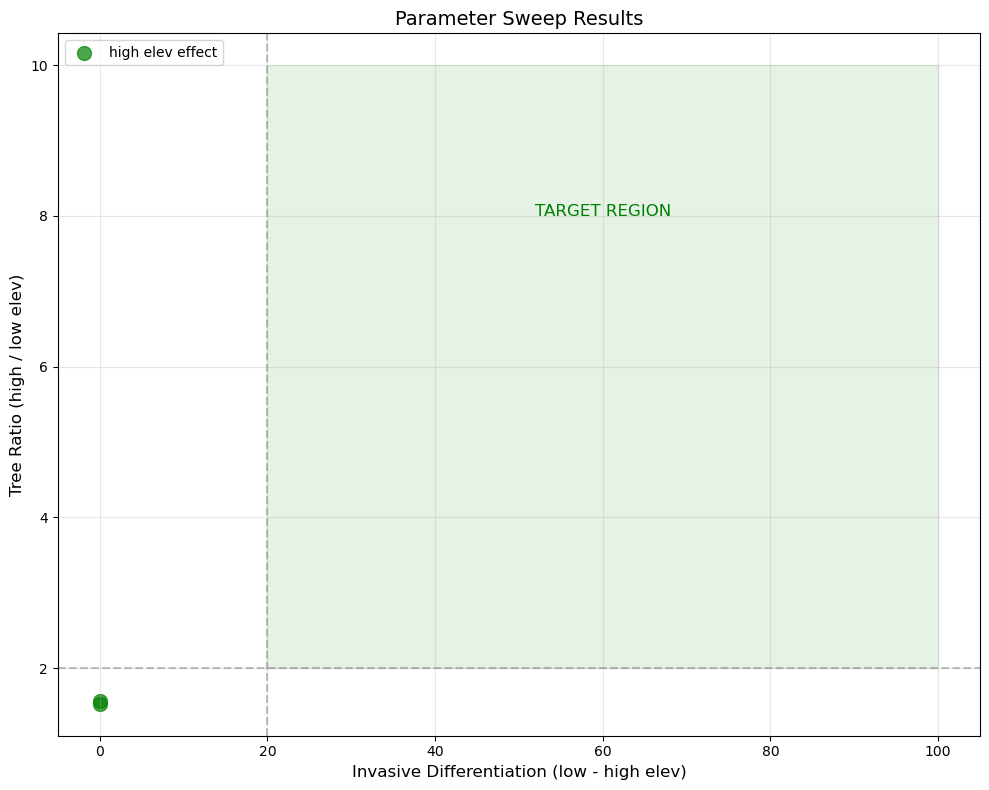

In [14]:
# Scatter plot: invasive differentiation vs tree ratio
if metrics_df is not None and len(metrics_df) > 0:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    colors = {'low': 'red', 'med': 'orange', 'high': 'green'}
    for elev in ['low', 'med', 'high']:
        subset = metrics_df[metrics_df['elev_effect'] == elev]
        if len(subset) > 0:
            ax.scatter(subset['invasive_diff'], subset['tree_ratio'], 
                      c=colors[elev], label=f'{elev} elev effect', s=100, alpha=0.7)
    
    # Mark good region
    ax.axvline(x=20, color='gray', linestyle='--', alpha=0.5)
    ax.axhline(y=2, color='gray', linestyle='--', alpha=0.5)
    ax.fill_between([20, 100], [2, 2], [10, 10], alpha=0.1, color='green')
    ax.text(60, 8, 'TARGET REGION', fontsize=12, color='green', ha='center')
    
    ax.set_xlabel('Invasive Differentiation (low - high elev)', fontsize=12)
    ax.set_ylabel('Tree Ratio (high / low elev)', fontsize=12)
    ax.set_title('Parameter Sweep Results', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'sweep_scatter.png', dpi=150, bbox_inches='tight')
    plt.show()

---

## Step 7: Export Best Configuration

Copy the best configuration to `configs/params.jshc` for use in the main demo.

In [15]:
# Export the best configuration for use in the main demo
if ranked is not None and len(ranked) > 0:
    best_scenario = ranked.iloc[0]['scenario']
    
    # Find the merged config file
    merged_config = RESULTS_DIR / f"{best_scenario}_merged.jshc"
    target_config = WORKSPACE / 'configs' / 'params.jshc'
    
    if merged_config.exists():
        print(f"Best configuration: {best_scenario}")
        print(f"Merged config: {merged_config}")
        print()
        print("To use this configuration in the main demo:")
        print(f"  import shutil")
        print(f"  shutil.copy('{merged_config}', '{target_config}')")
        print()
        print("Or from command line:")
        print(f"  cp {merged_config} {target_config}")
        print()
        
        # Show the sweep overrides section
        print("Sweep parameter overrides:")
        print("="*60)
        with open(merged_config) as f:
            content = f.read()
            if '=== SWEEP OVERRIDES ===' in content:
                print(content.split('=== SWEEP OVERRIDES ===')[1].strip())
            else:
                # Show last few lines if no marker found
                lines = content.strip().split('\n')
                for line in lines[-10:]:
                    print(line)
    else:
        print(f"Merged config not found: {merged_config}")
        print("Run the sweep first to generate merged configs.")

Best configuration: high_elev_effect_high_growth_high_threshold
Merged config: /workspace/results/sweep/high_elev_effect_high_growth_high_threshold_merged.jshc

To use this configuration in the main demo:
  import shutil
  shutil.copy('/workspace/results/sweep/high_elev_effect_high_growth_high_threshold_merged.jshc', '/workspace/configs/params.jshc')

Or from command line:
  cp /workspace/results/sweep/high_elev_effect_high_growth_high_threshold_merged.jshc /workspace/configs/params.jshc

Sweep parameter overrides:
elevationInvasiveGrowthReduction = 30 percent
invasiveBaseGrowthRate = 25 percent
nativeEstablishmentThreshold = 50 percent
seedlingElevationReduction = 35 percent
elevationInitialInvasiveReduction = 55 percent


---

## Summary

This workflow demonstrates:

1. **Systematic exploration** - Define parameter ranges in a CSV, generate configs automatically
2. **Batch execution** - Run all configurations with a single script
3. **Objective ranking** - Score configurations based on expected ecological patterns
4. **Visualization** - Heatmaps and scatter plots show parameter effects
5. **Export** - Best configuration can be copied to the main demo

### Key Metrics

| Metric | Target | Why |
|--------|--------|-----|
| `invasive_diff` | > 20% | More invasives at low elevation |
| `tree_ratio` | > 2x | More trees at high elevation |
| `high_invasive` | < 30% | High elevation suppresses invasives |
| `low_invasive` | > 50% | Low elevation has invasive problem |